In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('echocardiogram.data', sep=",", header=None)
df.columns = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion", "fractional-shortening",
            "epss", "lvdd", "wall-motion-score", "wall-motion-index", "mult", "name", "group", "alive-at-1"]
            
df.replace('?', np.nan, inplace=True)
df.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [7]:
df.drop(['alive-at-1', 'mult', 'group', 'name','wall-motion-score'], axis = 1, inplace = True)

for column in df:
    df[column] = pd.to_numeric(df[column])

for column in df:
    if column in ['still-alive', 'pericardial-effusion', 'survival']: continue
    df[column].fillna(df[column].mean().round(1), inplace = True)


df['age-at-heart-attack'] = df['age-at-heart-attack'].astype(np.int)
df = df.dropna()

df.rename(columns = {'still-alive': 'alive'}, inplace = True)

C:\Users\mashp\AppData\Local\Temp\ipykernel_19356\919627785.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['age-at-heart-attack'] = df['age-at-heart-attack'].astype(np.int)


In [8]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
outliers_rows = lof.fit_predict(df)
mask = outliers_rows != -1
df = df[mask]

In [9]:
df.info() # cleared

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 130
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               125 non-null    float64
 1   alive                  125 non-null    int64  
 2   age-at-heart-attack    125 non-null    int32  
 3   pericardial-effusion   125 non-null    int64  
 4   fractional-shortening  125 non-null    float64
 5   epss                   125 non-null    float64
 6   lvdd                   125 non-null    float64
 7   wall-motion-index      125 non-null    float64
dtypes: float64(5), int32(1), int64(2)
memory usage: 8.3 KB


In [10]:
# from sklearn.preprocessing import StandardScaler

# continuous_variables = [x for x in df.columns if x not in ['alive', 'pericardial-effusion']]

# scaler = StandardScaler()
# df[continuous_variables] = scaler.fit_transform(df[continuous_variables])

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['alive'], 1), df['alive'], test_size=0.25, random_state=42)
X_train.shape, X_test.shape

C:\Users\mashp\AppData\Local\Temp\ipykernel_19356\143692151.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop(['alive'], 1), df['alive'], test_size=0.25, random_state=42)


((93, 7), (32, 7))

In [32]:
models = {
    'LR': LogisticRegression(), 
    'NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'RF': RandomForestClassifier(max_depth=1, n_estimators=11)
    }

for n_neighbors in [1, 2, 3]:
    models[f'KNN (n = {n_neighbors})'] = KNeighborsClassifier(n_neighbors=n_neighbors)

for max_depth in [2, 4, 6]:
    models[f'D Tree (depth = {max_depth})'] = DecisionTreeClassifier(max_depth=max_depth)

In [34]:
for key, model in models.items():
    model.fit(X_train, y_train)

results = [model.score(X_test, y_test) for key, model in models.items()]
df_results = pd.DataFrame(results, index = models.keys(), columns = ['Accuracy'])

df_results

c:\Users\mashp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy
LR,0.87500
NB,0.87500
Multinomial NB,0.84375
RF,0.93750
KNN (n = 1),0.84375
KNN (n = 2),0.93750
KNN (n = 3),0.93750
D Tree (depth = 2),0.87500
D Tree (depth = 4),0.87500
D Tree (depth = 6),0.81250


In [14]:
# from sklearn import tree
# import graphviz

# decision_tree = RandomForestClassifier(max_depth=1, n_estimators=8, random_state=42).fit(X_train, y_train)
# res_pred = decision_tree.predict(X_test)
# print(accuracy_score(y_test, res_pred))

# dot_data = tree.export_graphviz(decision_tree.estimators_[3], out_file=None, 
#     feature_names=X_train.columns,    
#     filled=True, rounded=True,  
#     special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph 

In [15]:
test_patient = [11, 60, 0, 0.4, 7, 5, 1.11]
model.predict_proba([test_patient]) # 78% of death

c:\Users\mashp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.72952732, 0.27047268]])

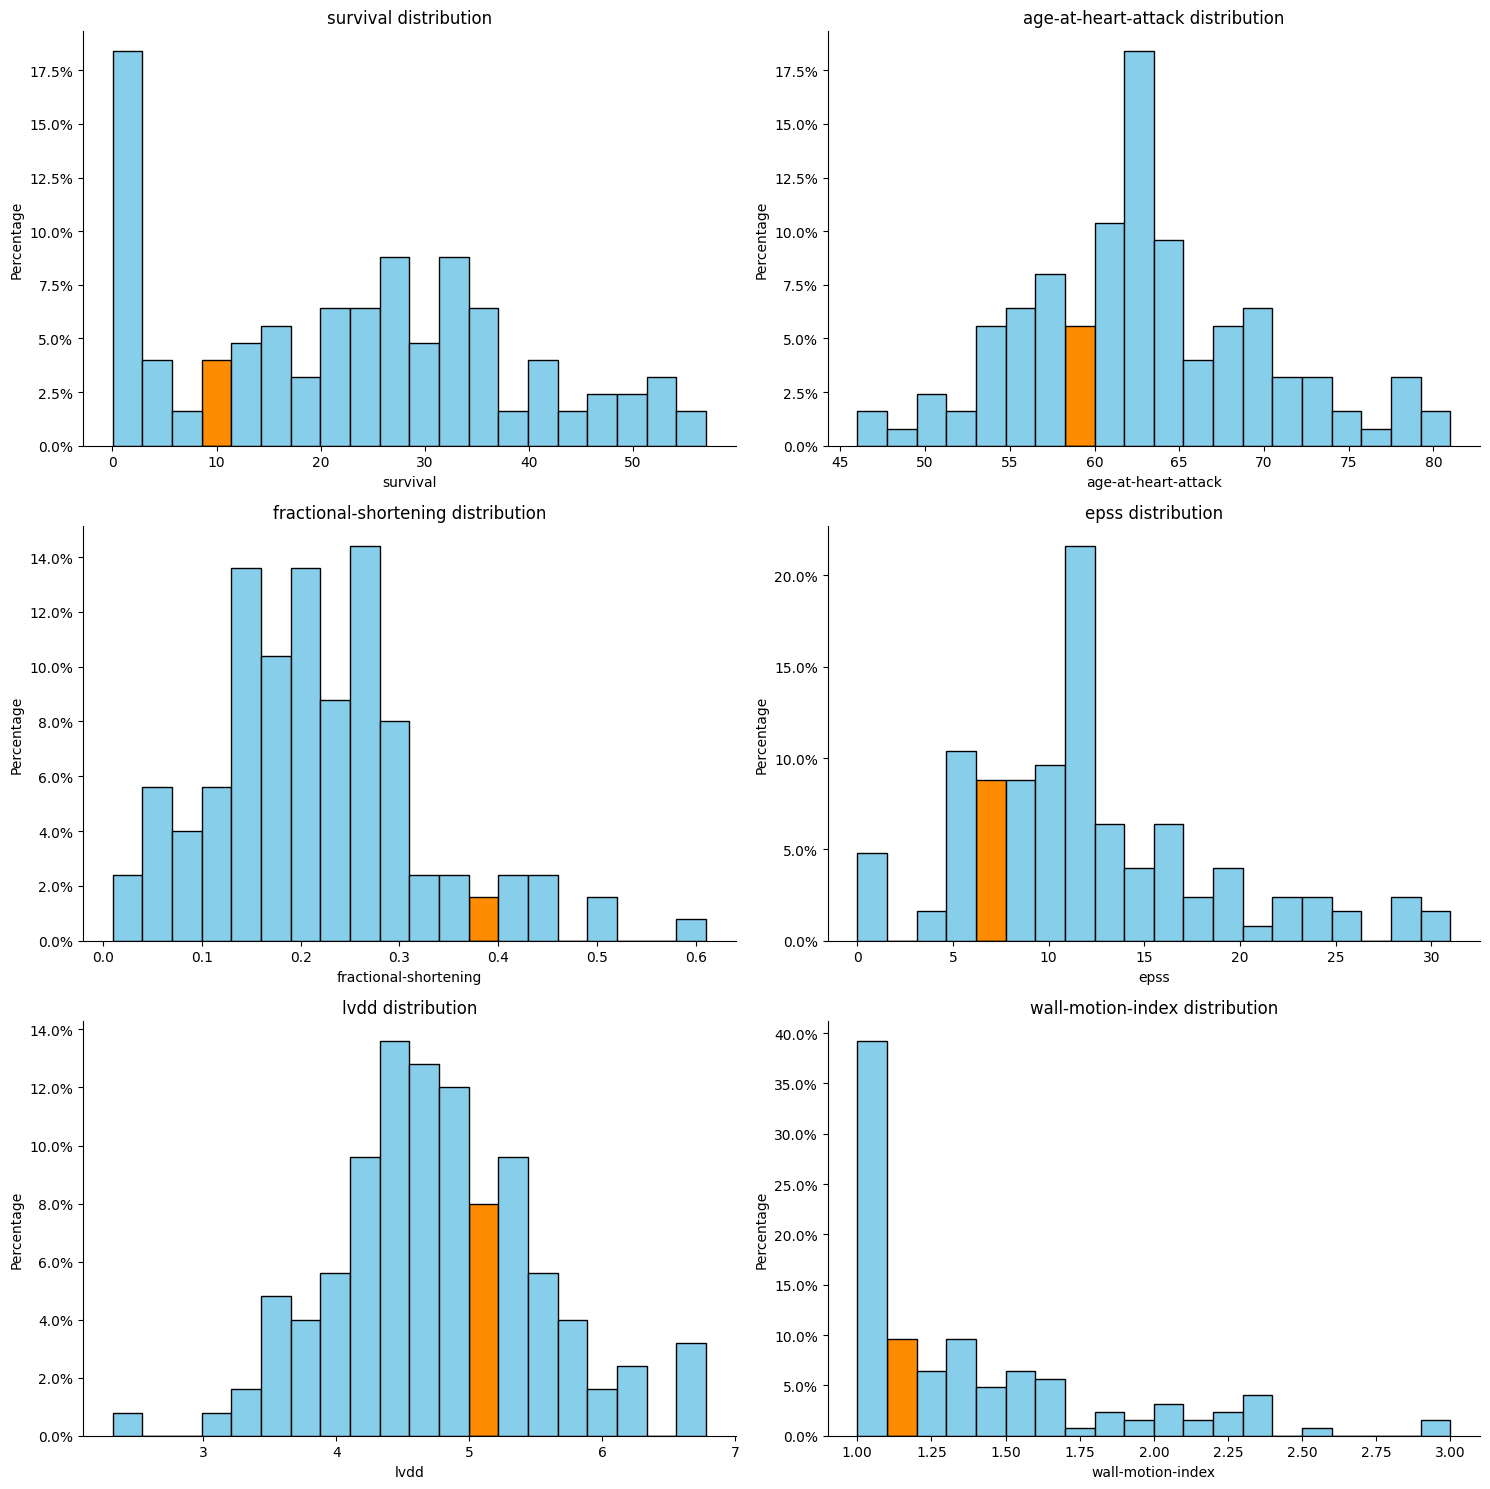

In [16]:
from matplotlib.ticker import PercentFormatter

def show_stats(test_patient):
    test_patient = np.delete(test_patient, 2) # remove categorical value

    data = df.drop(['alive', 'pericardial-effusion'], axis=1)
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))


    axes = axes.ravel()
    for idx, ax in enumerate(axes):

        value = test_patient[idx]
        ax_data = data.iloc[:, idx]
        bins = 20

        counts, bins = np.histogram(ax_data, bins=bins)

        bins_array = np.sort(np.append(bins, value))
        index = np.where(bins_array == value)[0][0]

        index_0 = bins[index - 1]
        if len(bins) == index: bins = bins_array
        else: index_1 = bins[index]

        x1 = ax_data[(ax_data < index_1) & (ax_data >= index_0)]
        x2 = ax_data[~((ax_data < index_1) & (ax_data >= index_0))]

        ax.hist(x1, bins=bins, edgecolor = "black", color='darkorange', weights=np.ones(len(x1)) / len(x1 + x2))
        ax.hist(x2, bins=bins, edgecolor = "black", color='skyblue', weights=np.ones(len(x2)) / len(x1 + x2))
        ax.yaxis.set_major_formatter(PercentFormatter(1))

        ax.set(xlabel=data.columns[idx], ylabel="Percentage", title="{} distribution".format(data.columns[idx]))

        plt.tight_layout()
        sns.despine()

show_stats(test_patient)